In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import time

### Model for MNIST

In [2]:
class Generator(nn.Module):
  def __init__(self):
    super().__init__()

    self.fc1 = nn.ConvTranspose2d(74, 1024, 1, 1)
    self.bn1 = nn.BatchNorm2d(1024) 

    self.fc2 = nn.ConvTranspose2d(1024, 128, 7, 1)
    self.bn2 = nn.BatchNorm2d(128)

    self.upconv3 = nn.ConvTranspose2d(128, 64, 4, 2, padding=1)
    self.bn3 = nn.BatchNorm2d(64)

    self.upconv4 = nn.ConvTranspose2d(64, 1, 4, 2, padding=1)

  def forward(self, x):
    x = self.fc1(x)
    x = self.bn1(x)
    x = F.relu(x)


    x = self.fc2(x)
    x = self.bn2(x)
    x = F.relu(x)

    x = self.upconv3(x)
    x = self.bn3(x)
    x = F.relu(x)

    x = F.tanh(self.upconv4(x))

    return x

In [3]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(1, 64, 4, 2, 1)

    self.conv2 = nn.Conv2d(64, 128, 4, 2, 1)
    self.bn2 = nn.BatchNorm2d(128)

    self.fc3 = nn.Conv2d(128, 1024, 7)
    self.bn3 = nn.BatchNorm2d(1024)

  def forward(self, x):

    x = F.leaky_relu(self.conv1(x), 0.1)
    x = F.leaky_relu(self.bn2(self.conv2(x)), 0.1)
    x = F.leaky_relu(self.bn3(self.fc3(x)), 0.1)

    return x

In [4]:
class DiscriminatorHead(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc = nn.Conv2d(1024, 1, 1)

  def forward(self, x):
    x = torch.sigmoid(self.fc(x))
    return x

In [5]:
class QHead(nn.Module):
  def __init__(self):
    super().__init__()

    self.fc1 = nn.Conv2d(1024, 128, 1)
    self.bn1 = nn.BatchNorm2d(128)

    self.fc2 = nn.Conv2d(128, 10, 1)
    
    #for Gaussian - contin. noise parameters
    self.conv_mu = nn.Conv2d(128, 2, 1)
    self.conv_var = nn.Conv2d(128, 2, 1)

  def forward(self, x):
    x = F.leaky_relu(self.bn1(self.fc1(x)), 0.1)
    mu = self.conv_mu(x).squeeze()
    var = torch.exp(self.conv_var(x).squeeze())
    x = self.fc2(x).squeeze()
    
    return x, mu, var

In [6]:
device = torch.device("cuda:0" if(torch.cuda.is_available()) else "cpu")
print(device)

cuda:0


In [7]:
transform = transforms.Compose([transforms.Resize(28), transforms.CenterCrop(28), transforms.ToTensor()])
dataset = datasets.MNIST('data/mnist/', train='train', download=True, transform=transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to data/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to data/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to data/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/mnist/MNIST/raw



In [8]:
batch_size = 128
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [9]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [10]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)
head_disc = DiscriminatorHead().to(device)
head_q = QHead().to(device)

generator.apply(weights_init)
discriminator.apply(weights_init)
head_disc.apply(weights_init)
head_q.apply(weights_init)

QHead(
  (fc1): Conv2d(1024, 128, kernel_size=(1, 1), stride=(1, 1))
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Conv2d(128, 10, kernel_size=(1, 1), stride=(1, 1))
  (conv_mu): Conv2d(128, 2, kernel_size=(1, 1), stride=(1, 1))
  (conv_var): Conv2d(128, 2, kernel_size=(1, 1), stride=(1, 1))
)

In [11]:
def GaussianLoss(x, mu, var):
    #Loss for con. code, eps for numerical stability
    eps = 1e-6
    return ((1/2 * torch.log(2 * torch.pi * var + eps) + ((x - mu)**2)/(2 * var + eps)).sum(axis = 1)).mean()

In [12]:
criterionD = nn.BCELoss()
criterionQ_dis = nn.CrossEntropyLoss() #because of using softmax

In [13]:
#lr from paper, betas from other implementations
optimD = optim.Adam([{'params': discriminator.parameters()}, {'params': head_disc.parameters()}], lr=2e-4, betas=(0.5, 0.999))
optimG = optim.Adam([{'params': generator.parameters()}, {'params': head_q.parameters()}], lr=1e-3, betas=(0.5, 0.999))

In [14]:
fixed_noise = torch.randn(100, 62, 1, 1, device=device)
con = torch.rand(100, 2, 1, 1, device=device) * 2 - 1 #from -1 to 1
x = np.arange(10).repeat(10)
dis = torch.zeros(100, 1, 10, device=device)
dis[torch.arange(100), 0, x] = 1 
dis = dis.view(100, -1, 1, 1)

In [15]:
fixed_noise = torch.cat((fixed_noise, dis, con), dim=1)

images = []
G_losses = []
D_losses = []

num_epochs = 50

In [16]:
#preparing for celebA and chairs
def noise_function(n_dis, dis_dim, n_con, num_z, batch_size, device):
    z = torch.randn(batch_size, num_z, 1, 1, device=device)

    idx = np.zeros((n_dis, batch_size))
    idx[0] = np.random.randint(dis_dim, size=batch_size)
    
    dis = torch.zeros(batch_size, n_dis, dis_dim, device=device)
    dis[torch.arange(0, batch_size), 0, idx[0]] = 1.0
    dis = dis.view(batch_size, -1, 1, 1)
    
    con = torch.rand(batch_size, n_con, 1, 1, device=device) * 2 - 1
    noise = torch.cat((z, dis, con), dim=1)

    return noise, idx

In [17]:
for epoch in range(num_epochs):
    for i, (batch, _) in enumerate(dataloader, 0):
        
        batch_size = batch.size(0)

        #discriminator
        optimD.zero_grad()
        label = torch.full((batch.size(0), ), 1, device=device)
        output_real = discriminator(batch.to(device))
        probs_real = head_disc(output_real).view(-1)
        loss_real = criterionD(probs_real.to(torch.float32), label.to(torch.float32))
        loss_real.backward()
        label.fill_(0)
        noise, idx = noise_function(1, 10, 2, 62, batch.size(0), device)
        data_from_noise = generator(noise)
        probs_noise = head_disc(discriminator(data_from_noise.detach())).view(-1)
        loss_noise = criterionD(probs_noise.to(torch.float32), label.to(torch.float32))
        loss_noise.backward()
        D_loss = loss_real + loss_noise
        optimD.step()

        #generator
        optimG.zero_grad()
        output_noise = discriminator(data_from_noise)
        label.fill_(1)
        probs_noise = head_disc(output_noise).view(-1)
        generator_loss = criterionD(probs_noise.to(torch.float32), label.to(torch.float32))
        q_logits, q_mu, q_var = head_q(output_noise)
        target = torch.LongTensor(idx).to(device)
        dis_loss = criterionQ_dis(q_logits[:, 0:10], target[0])
        con_loss = GaussianLoss(noise[:, 72: ].view(-1, 2), q_mu, q_var)/10

        #lambda = 1
        G_loss = generator_loss + dis_loss + con_loss
        G_loss.backward()
        optimG.step()

        if i == 200:
            print('epoch {} of {}\nLoss_D:{} \tLoss_G: {}'.format(epoch+1, num_epochs, D_loss.item(), G_loss.item()))
                 
        G_losses.append(G_loss.item())
        D_losses.append(D_loss.item())

    
    with torch.no_grad():
        gen_data = generator(fixed_noise).detach().cpu()
    images.append(vutils.make_grid(gen_data, nrow=10, padding=2, normalize=True))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


epoch 1 of 50
Loss_D:1.043520212173462 	Loss_G: 0.9298844337463379
epoch 2 of 50
Loss_D:0.955415666103363 	Loss_G: 1.2548320293426514
epoch 3 of 50
Loss_D:1.0804885625839233 	Loss_G: 1.2074556350708008
epoch 4 of 50
Loss_D:1.089257836341858 	Loss_G: 0.9951211214065552
epoch 5 of 50
Loss_D:1.034999966621399 	Loss_G: 1.0395452976226807
epoch 6 of 50
Loss_D:1.0375514030456543 	Loss_G: 1.0195693969726562
epoch 7 of 50
Loss_D:1.113600730895996 	Loss_G: 1.305736780166626
epoch 8 of 50
Loss_D:0.9903205633163452 	Loss_G: 1.3426350355148315
epoch 9 of 50
Loss_D:1.0184743404388428 	Loss_G: 1.0788190364837646
epoch 10 of 50
Loss_D:1.016378402709961 	Loss_G: 1.3816531896591187
epoch 11 of 50
Loss_D:0.9488376379013062 	Loss_G: 1.3942734003067017
epoch 12 of 50
Loss_D:0.9429477453231812 	Loss_G: 1.3276333808898926
epoch 13 of 50
Loss_D:0.873958945274353 	Loss_G: 1.26357901096344
epoch 14 of 50
Loss_D:0.8904563188552856 	Loss_G: 1.5429813861846924
epoch 15 of 50
Loss_D:0.8269529938697815 	Loss_G: 1.7

Проверяем, как работает генератор:

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


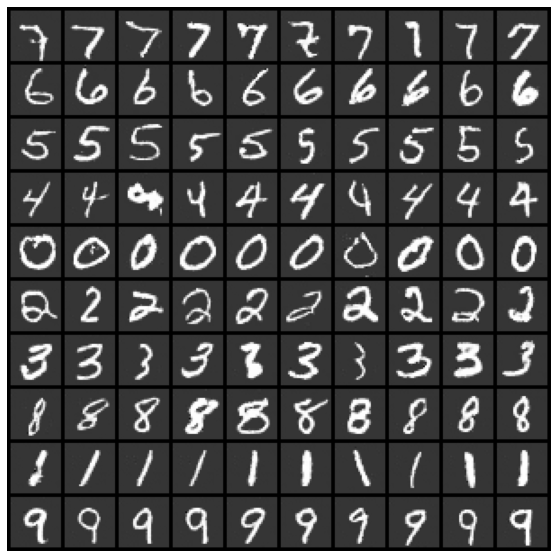

In [18]:
with torch.no_grad():
    gen_data = generator(fixed_noise).detach().cpu()
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(gen_data, nrow=10, padding=2, normalize=True), (1,2,0)))

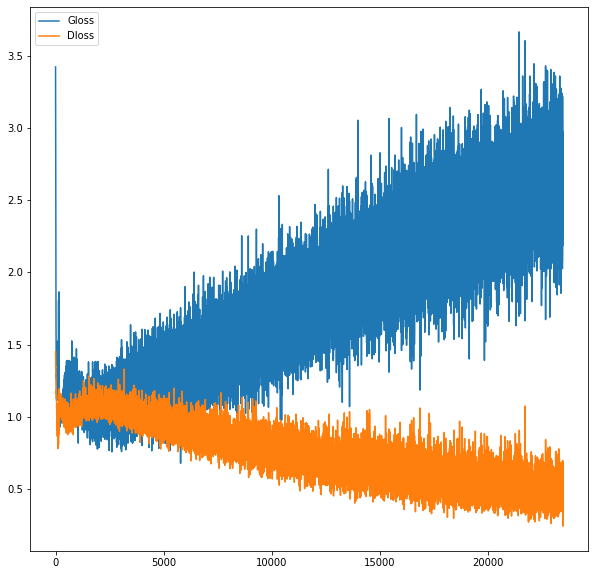

In [19]:
plt.figure(figsize = (10, 10))
plt.plot(G_losses, label = 'Gloss')
plt.plot(D_losses, label = 'Dloss')
plt.legend()
plt.show()

Генератор после нескольких эпох: 0, 10, 20, 30, 40.

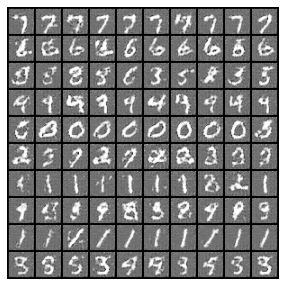

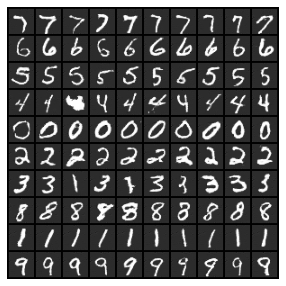

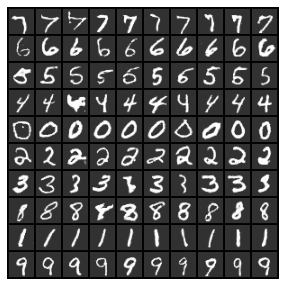

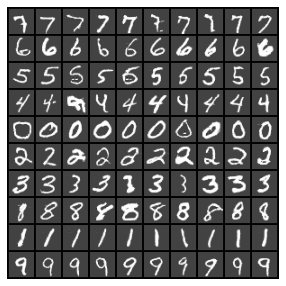

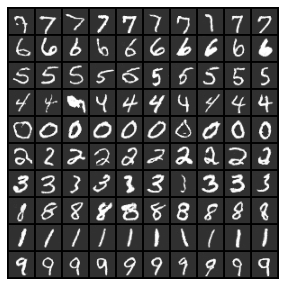

In [36]:
for i in range(num_epochs//10):
  plt.figure(figsize=(5, 5))
  plt.imshow(np.transpose(images[i*10], (1, 2, 0)))
  plt.axis("off")
  plt.show()

Пробуем разные переменные

In [169]:
fixed_noise_ = torch.randn(100, 62, 1, 1, device=device)
con1 = (torch.arange(100, device=device)/25 - 2).view(100, -1, 1, 1)  #from -2 to 2
con2 = torch.rand(100, 1, 1, 1, device=device)
x_ = np.arange(10).repeat(10)
dis_ = torch.zeros(100, 1, 10, device=device)
dis_[torch.arange(100), 0, x_] = 1 
dis_ = dis_.view(100, -1, 1, 1)
fixed_noise_ = torch.cat((fixed_noise_, dis_, con1, con2), dim=1)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


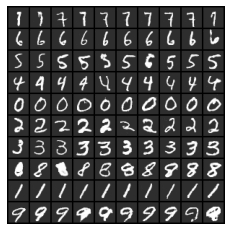

In [170]:
with torch.no_grad():
  gen_data = generator(fixed_noise_).detach().cpu()
plt.figure(figsize=(4, 4))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(gen_data, nrow=10, padding=2, normalize=True), (1,2,0)))

In [139]:
def fix_noise_gen(f):
  fixed_noise_ = f
  con2 = (torch.arange(100, device=device)*6/100-3).view(100, -1, 1, 1)  #from -2 to 2
  con1 = torch.ones(100, 1, 1, 1, device=device)
  x_ = np.arange(10).repeat(10)
  dis_ = torch.zeros(100, 1, 10, device=device)
  dis_[torch.arange(100), 0, x_] = 1 
  dis_ = dis_.view(100, -1, 1, 1)
  fixed_noise_ = torch.cat((fixed_noise_, dis_, con1, con2), dim=1)
  return fixed_noise_

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


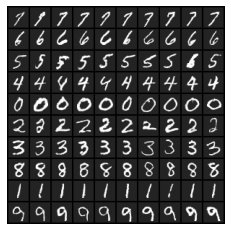

In [140]:
f = torch.randn(100, 62, 1, 1, device=device)
fixed_noise_ = fix_noise_gen(f)
with torch.no_grad():
  gen_data = generator(fixed_noise_).detach().cpu()
plt.figure(figsize=(4, 4))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(gen_data, nrow=10, padding=2, normalize=True), (1,2,0)))

Пока не видно каких-то интерпретируемых зависимостей, как у авторов. Возможно, наша сеть недостаточно обучилась - возможно, интервалы нужно подобрать другие. Однако есть хорошие предпоссылки - наклон на 1 картинке